In [1]:
import mpmath
%load_ext autoreload
%autoreload 2
from qiskit.ignis.verification import state_tomography_circuits, StateTomographyFitter
from qiskit.tools import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from hdf5_reader import Hdf5Reader
from basic_decomposer import BasicDecomposer
from qiskit import *
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
IBMQ.save_account(
    '280beccbee94456a161a6cbc217e1366bc278bf60e22bd30281fa0ca5bec6e50897278ef818f3c53f6700e04b9ed32ea364195044413b7e02836a79d886b03d9',
    overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')


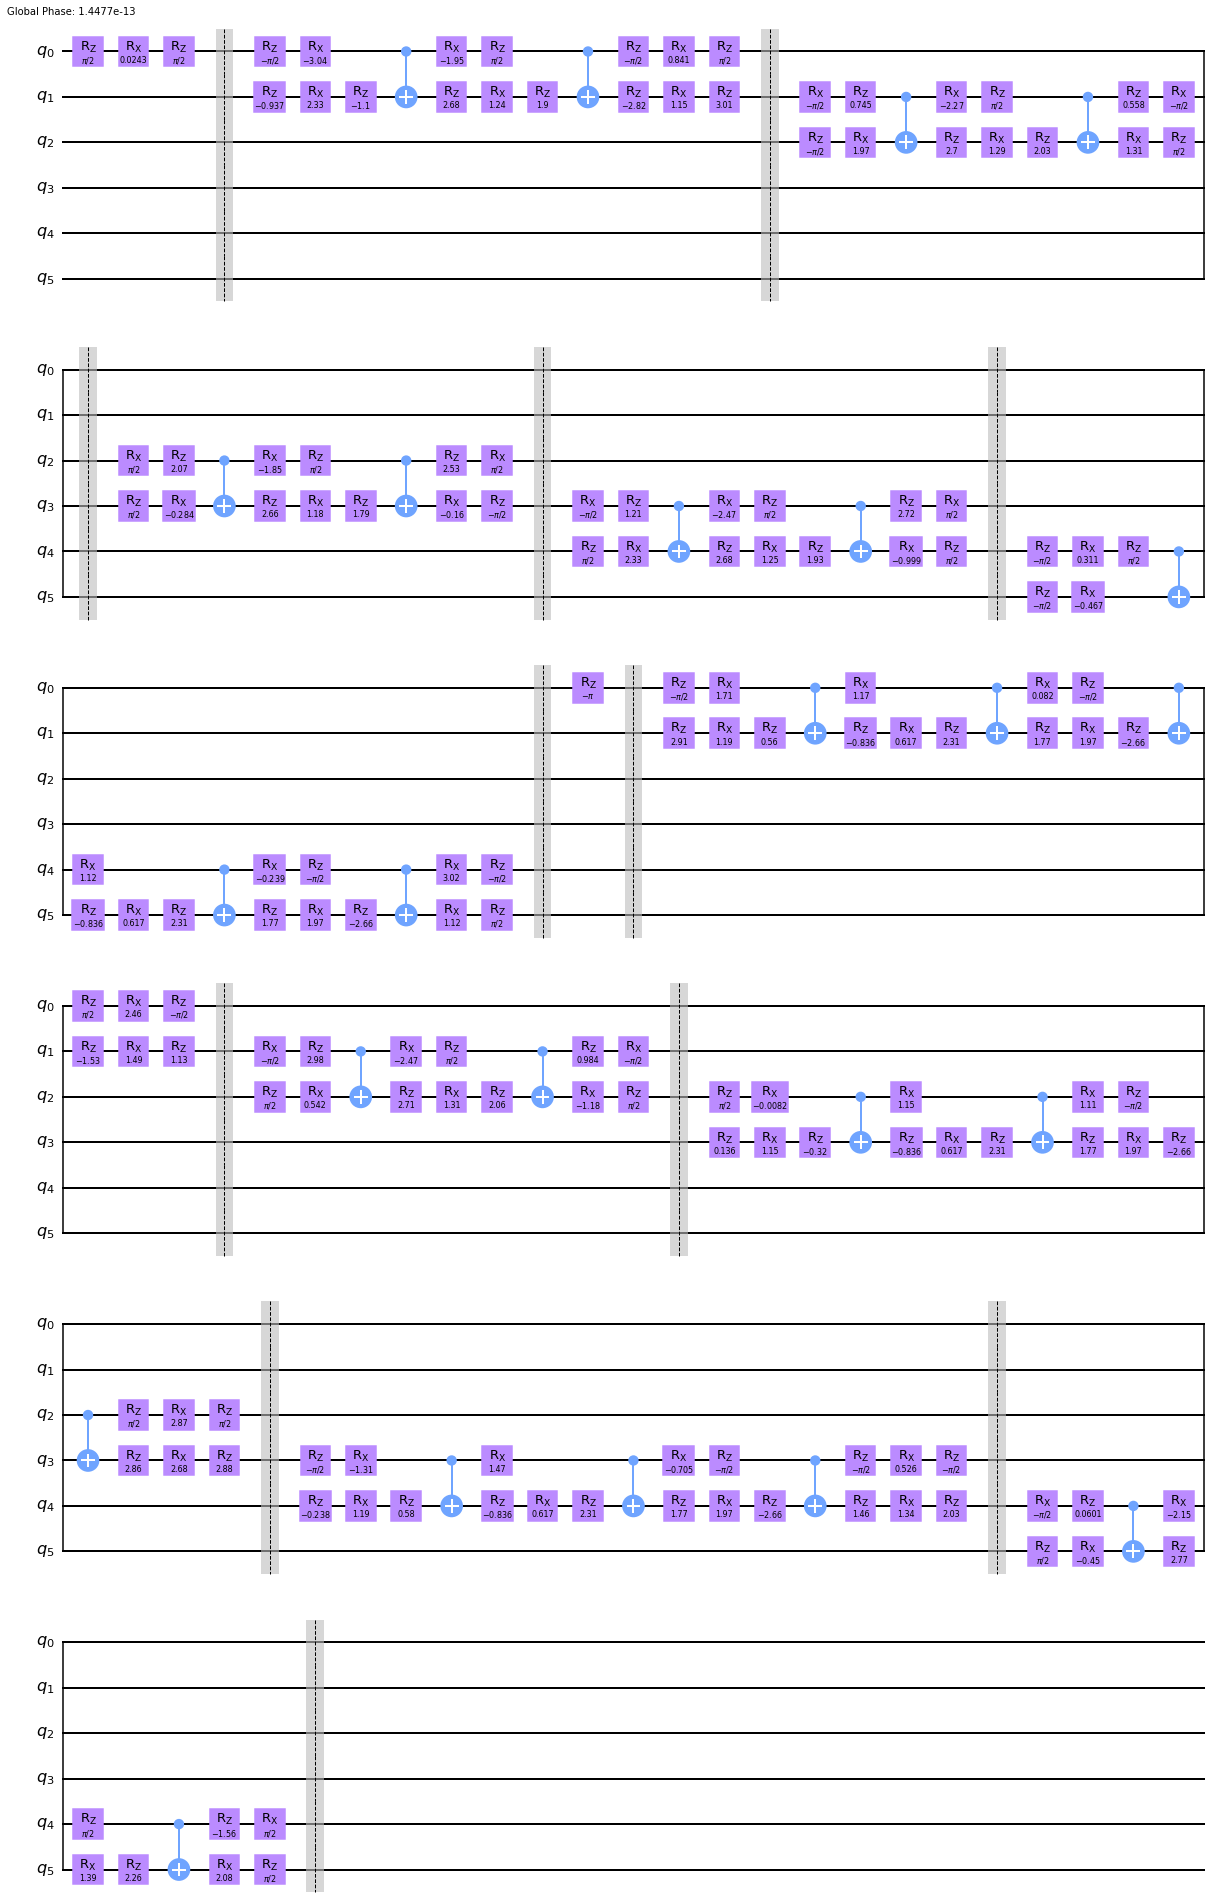

In [2]:
reader1 = Hdf5Reader("new_2layers_6qubits.h5").get_adapter()
decomposer = BasicDecomposer(reader1)
circuit1 = decomposer.decompose(barrier=True)
reader2 = Hdf5Reader("new_2layers_6qubits_good.h5").get_adapter()
circuit2 = BasicDecomposer(reader2).decompose(barrier=True)
circuit2.draw(output='mpl')

In [3]:
reversed_circuit1 = circuit1.inverse()
reversed_circuit2 = circuit2.inverse()

In [4]:
import qiskit.quantum_info as qi
import numpy as np

state_vector1 = qi.Statevector.from_instruction(reversed_circuit1)
state_vector2 = qi.Statevector.from_instruction(reversed_circuit2)

vector_dot1 = np.vdot(state_vector1.data, reader1.get_psi())
vector_dot2 = np.vdot(state_vector2.data, reader2.get_psi())

print("Scalar product (circuit 1): " , np.abs(vector_dot1))
print("Scalar product (circuit 2): " , np.abs(vector_dot2))


Scalar product (circuit 1):  0.7528133156902352
Scalar product (circuit 2):  0.8620178628347499


In [5]:
#Create Tomography circuits
tomo_circuit1 = state_tomography_circuits(reversed_circuit1, reversed_circuit1.qubits)
tomo_circuit2 = state_tomography_circuits(reversed_circuit2, reversed_circuit2.qubits)

## $$\huge \text{Simulator}$$

In [11]:
import qiskit

# Generate the state tomography circuits.
job1 = qiskit.execute(tomo_circuit1, Aer.get_backend('qasm_simulator'), shots=16000)
job_monitor(job1)
tomo_fitter_circuit1 = StateTomographyFitter(job1.result(), tomo_circuit1)

rho_fit_circuit1 = tomo_fitter_circuit1.fit(method='lstsq')
F_1 = qi.state_fidelity(rho_fit_circuit1, reader1.get_psi())
print('State Fidelity (circuit 1): F = {:.5f}'.format(F_1))

Job Status: job has successfully run
State Fidelity (circuit 1): F = 0.97272


In [36]:
# Generate the state tomography circuits.
job2 = qiskit.execute(tomo_circuit2, Aer.get_backend('qasm_simulator'), shots=8000)
job_monitor(job2)
tomo_fitter_circuit2 = StateTomographyFitter(job2.result(), tomo_circuit2)

rho_fit_circuit2 = tomo_fitter_circuit2.fit(method='lstsq')
F_2 = qi.state_fidelity(rho_fit_circuit2, reader2.get_psi())
print('State Fidelity (circuit 2): F = {:.5f}'.format(F_2))

Job Status: job has successfully run
State Fidelity (circuit 2): F = 0.74266


## $$\huge \text{Combined Simulator}$$

In [6]:
import qiskit

# Generate the state tomography circuits.
part1_1 = []
part2_1 = []
part3_1 = []
for i in range(len(tomo_circuit1)):
    if i <= 250:
        part1_1.append(tomo_circuit1[i])
    elif i <= 500:
        part2_1.append(tomo_circuit1[i])
    elif i <= 750:
        part3_1.append(tomo_circuit1[i])


In [7]:
job1_1 = qiskit.execute(part1_1, Aer.get_backend('qasm_simulator'), shots=8000)
job_monitor(job1_1)


Job Status: job has successfully run


In [8]:
job2_1 = qiskit.execute(part2_1, Aer.get_backend('qasm_simulator'), shots=8000)
job_monitor(job2_1)

Job Status: job has successfully run


In [9]:
job3_1 = qiskit.execute(part3_1, Aer.get_backend('qasm_simulator'), shots=8000)
job_monitor(job3_1)

Job Status: job has successfully run


In [10]:
from qiskit.quantum_info import Statevector
import Tomography.tomography
import importlib
full_counts = job1_1.result().get_counts() +job2_1.result().get_counts() + job3_1.result().get_counts()
matrix_sim_com = Tomography.tomography.get_density_matrix(full_counts, 0);
fid_sim_com = Tomography.tomography.calc_fidelity(matrix_sim_com,Statevector(reader2.get_psi()));


0


In [11]:
print(fid_sim_com)

(0.5666208078788046-2.168404344971009e-19j)


## $$\huge \text{Noise Simulator}$$

In [17]:
# Generate the state tomography circuits.
name = 'ibm_lagos'
backend = provider.get_backend(name)
noise_model = NoiseModel.from_backend(backend)
basis_gates = noise_model.basis_gates


job1_N = qiskit.execute(tomo_circuit1, Aer.get_backend('qasm_simulator'), basis_gates=basis_gates,
                                  noise_model=noise_model, shots=8000)
job_monitor(job1_N)
tomo_fitter_circuit1 = StateTomographyFitter(job1_N.result(), tomo_circuit1)

rho_fit_circuit1 = tomo_fitter_circuit1.fit(method='lstsq')
F_1 = qi.state_fidelity(rho_fit_circuit1, reader1.get_psi())
print('State Fidelity (circuit 1): F = {:.5f}'.format(F_1))

Job Status: job has successfully run
State Fidelity (circuit 1): F = 0.43916


In [18]:
# Generate the state tomography circuits.
name = 'ibm_lagos'
backend = provider.get_backend(name)
noise_model = NoiseModel.from_backend(backend)
basis_gates = noise_model.basis_gates


job2_N = qiskit.execute(tomo_circuit2, Aer.get_backend('qasm_simulator'), basis_gates=basis_gates,
                                  noise_model=noise_model, shots=8000)
job_monitor(job2_N)
tomo_fitter_circuit2 = StateTomographyFitter(job2_N.result(), tomo_circuit2)

rho_fit_circuit2 = tomo_fitter_circuit2.fit(method='lstsq')
F_2 = qi.state_fidelity(rho_fit_circuit2, reader2.get_psi())
print('State Fidelity (circuit 2): F = {:.5f}'.format(F_2))

Job Status: job has successfully run
State Fidelity (circuit 2): F = 0.57253


## $$\huge \text{Lagos}$$

In [21]:
# Generate the state tomography circuits.
backend = provider.get_backend('ibm_lagos')

job1 = qiskit.execute(tomo_circuit1, backend, shots=8000,optimization_level=0)
job_monitor(job1)
tomo_fitter_circuit1 = StateTomographyFitter(job1.result(), tomo_circuit1)

rho_fit_circuit1 = tomo_fitter_circuit1.fit(method='lstsq')
F_1 = qi.state_fidelity(rho_fit_circuit1, reader1.get_psi())
print('State Fidelity (circuit 1): F = {:.5f}'.format(F_1))

Job Status: job has successfully run
State Fidelity (circuit 1): F = 0.16310


In [22]:
# Generate the state tomography circuits.
job2 = qiskit.execute(tomo_circuit2, backend, shots=8000,optimization_level=0)
job_monitor(job2)
tomo_fitter_circuit2 = StateTomographyFitter(job2.result(), tomo_circuit2)

rho_fit_circuit2 = tomo_fitter_circuit2.fit(method='lstsq')
F_2 = qi.state_fidelity(rho_fit_circuit2, reader1.get_psi())
print('State Fidelity (circuit 2): F = {:.5f}'.format(F_2))

Job Status: job has successfully run
State Fidelity (circuit 2): F = 0.16501


In [ ]:
from Tomography import utility

utility.save_job(job1,"Lagos_simplecase_twolayers1_no_optimization")
utility.save_job(job2,"Lagos_simplecase_twolayers2_no_optimization")

## $$\huge \text{Lagos_comb}$$

In [ ]:
import qiskit

# Generate the state tomography circuits.
part1_1 = []
part2_1 = []
part3_1 = []
for i in range(len(tomo_circuit1)):
    if i <= 250:
        part1_1.append(tomo_circuit2[i])
    elif i <= 500:
        part2_1.append(tomo_circuit2[i])
    elif i <= 750:
        part3_1.append(tomo_circuit2[i])


In [16]:
backend = provider.get_backend('ibm_lagos')
noise_model = NoiseModel.from_backend(backend)
basis_gates = noise_model.basis_gates

job1_1 = qiskit.execute(part1_1, backend, shots=8000)
#job1_2 = qiskit.execute(part1_1, backend, shots=8000)
job_monitor(job1_1)


Job Status: job has successfully run


In [17]:
job2_1 = qiskit.execute(part2_1, backend, shots=8000)
#job2_2 = qiskit.execute(part2_1, backend, shots=8000)
job_monitor(job2_1)

Job Status: job has successfully run


In [18]:
job3_1 = qiskit.execute(part3_1, backend, shots=8000)
#job3_2 = qiskit.execute(part3_1, backend, shots=8000)
job_monitor(job3_1)

Job Status: job has successfully run


In [19]:
from qiskit.quantum_info import Statevector
import Tomography.tomography
import importlib
importlib.reload(Tomography.tomography)
full_counts = job1_1.result().get_counts() +job2_1.result().get_counts()+job3_1.result().get_counts()
print(len(full_counts))
matrix_sim_com = Tomography.tomography.get_density_matrix(full_counts, 0);
fid_sim_com = Tomography.tomography.calc_fidelity(matrix_sim_com,Statevector(reader2.get_psi()));

729
0


In [20]:
print(fid_sim_com)

(0.0314720972909254+0j)


In [142]:
from Tomography import utility

utility.save_job(job1_1,"Lagos_6qubits_optimized_part1")
utility.save_job(job2_1,"Lagos_6qubits_optimized_part2")
utility.save_job(job3_1,"Lagos_6qubits_optimized_part3")

## $$\huge \text{Reduced}$$

In [11]:
reduced = decomposer._gate_list[0] + decomposer._gate_list[1] + decomposer._gate_list[2] + decomposer._gate_list[3] + decomposer._gate_list[4]
reduced.draw(output='mpl')
reversed_reduced = reduced.inverse()

state_vector_red = qi.Statevector.from_instruction(reversed_reduced)
reduced_product = np.vdot(state_vector_red.data, reader1.get_psi())
print("Scalar product (Reduced circuit): " , np.abs(reduced_product))

#print("Scalar product (circuit 3): " , np.abs(vector_dot3))


Scalar product (Reduced circuit):  0.8905365145361812


In [38]:
tomo_circuit_red = state_tomography_circuits(reversed_reduced, reversed_reduced.qubits)
backend = provider.get_backend('ibm_lagos')

job_red = qiskit.execute(tomo_circuit_red, backend, shots=8000,optimization_level=0)
job_monitor(job_red)


c:\python-interpreters\lib\site-packages\qiskit\execute_function.py:399: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


TypeError: Object of type NoiseModel is not JSON serializable

In [36]:
import qiskit.quantum_info as qi

job_red = utility.retrieve("Lagos_new_3layers_5qubits (3).h5_before error mitigation")
tomo_fitter_red = StateTomographyFitter(job_red.result(), tomo_circuit_red)

rho_fit_red = tomo_fitter_red.fit(method='lstsq')
F_1 = qi.state_fidelity(rho_fit_red, reader1.get_psi())
print('State Fidelity (circuit 1): F = {:.5f}'.format(F_1))

Retrieved from memory
State Fidelity (circuit 1): F = 0.27503


In [14]:
from Tomography import utility

utility.save_job(job_red,"Lagos_new_3layers_5qubits (3).h5_before error mitigation")

c:\python-interpreters\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
c:\python-interpreters\lib\site-packages\sympy\core\expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


## $$\huge \text{Mitigate Error}$$

In [24]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
from qiskit.providers.aer import noise
qr = qiskit.QuantumRegister(reduced.num_qubits)
qubit_list = [0,1,2,3,4]
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')



In [41]:
from qiskit.providers.aer.noise import NoiseModel

# Generate a noise model for the 5 qubits
noise_model = NoiseModel.from_backend(provider.get_backend('ibm_lagos'))
# Execute the calibration circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()
# Calculate the calibration matrix with the noise model
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.939 0.031 0.011 ... 0.    0.    0.   ]
 [0.017 0.933 0.001 ... 0.    0.    0.   ]
 [0.012 0.001 0.921 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.923 0.    0.008]
 [0.    0.    0.    ... 0.    0.923 0.017]
 [0.    0.    0.    ... 0.014 0.018 0.937]]


In [43]:
import qiskit.quantum_info as qi

meas_filter = meas_fitter.filter
mitigated_results = meas_filter.apply(job_red.result())

tomo_fitter_red = StateTomographyFitter(mitigated_results, tomo_circuit_red)

rho_fit_red = tomo_fitter_red.fit(method='lstsq')
F_1 = qi.state_fidelity(rho_fit_red, reader1.get_psi())
print('State Fidelity (circuit 1): F = {:.5f}'.format(F_1))

State Fidelity (circuit 1): F = 0.30224


## $$\huge \text{Jakarta}$$


In [ ]:
# Generate the state tomography circuits.
backend = provider.get_backend('ibmq_jakarta')
job1 = qiskit.execute(tomo_circuit1, backend, shots=8000,optimization_level=0)
job_monitor(job1)
tomo_fitter_circuit1 = StateTomographyFitter(job1.result(), tomo_circuit1)

rho_fit_circuit1 = tomo_fitter_circuit1.fit(method='lstsq')
F_1 = qi.state_fidelity(rho_fit_circuit1, reader1.get_psi())
print('State Fidelity (circuit 1): F = {:.5f}'.format(F_1))

In [2]:
# Generate the state tomography circuits.
job2 = qiskit.execute(tomo_circuit1, backend, shots=8000,optimization_level=0)
job_monitor(job2)
tomo_fitter_circuit2 = StateTomographyFitter(job2.result(), tomo_circuit2)

rho_fit_circuit2 = tomo_fitter_circuit2.fit(method='lstsq')
F_2 = qi.state_fidelity(rho_fit_circuit2, reader1.get_psi())
print('State Fidelity (circuit 2): F = {:.5f}'.format(F_2))

NameError: name 'qiskit' is not defined

In [6]:
from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    resource_id = "/subscriptions/719f8847-f147-4e34-84e9-4f74ac1c220f/resourceGroups/dallatorre-new/providers/Microsoft.Quantum/Workspaces/nonlocal-new",
    location = "westus"
)

In [7]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

This workspace's targets:
- ionq.qpu
- ionq.simulator
- quantinuum.hqs-lt-s1
- quantinuum.hqs-lt-s1-apival
- quantinuum.hqs-lt-s2
- quantinuum.hqs-lt-s2-apival
- quantinuum.hqs-lt-s1-sim
- quantinuum.hqs-lt-s2-sim


In [14]:
# Create a quantum circuit acting on a single qubit
circuitf = QuantumCircuit(1,1)
circuitf.name = "Single qubit random"
circuitf.h(0)
circuitf.measure(0, 0)

# Print out the circuit
circuitf.draw()

┌───┐┌─┐
  q: ┤ H ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0

In [16]:
backend = provider.get_backend("quantinuum.hqs-lt-s1")
cost = backend.estimate_cost(tomo_circuit1[0], shots=200)
print(f"Estimated cost: {cost.estimated_total} {cost.currency_code}")

Estimated cost: 27.32 HQC


In [ ]:
# Generate the state tomography circuits.
import qiskit
#import Tomography.tomography

backend = provider.get_backend("ionq.qpu")
counts = []
i = 0
for cir in tomo_circuit2:
    counts.append(backend.run(cir, shots=200).result().get_counts(cir))
    print(i)
    i+=1
#job_monitor(job1)
#tomo_fitter_circuit1 = StateTomographyFitter(job1.result(), tomo_circuit1)

#rho_fit_circuit1 = tomo_fitter_circuit1.fit(method='lstsq')
#F_1 = qi.state_fidelity(rho_fit_circuit1, reader1.get_psi())
#print('State Fidelity (circuit 1): F = {:.5f}'.format(F_1))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
import pickle

with open('simulator_job_6q_real_optimized(matan).pkl', 'wb') as outp:
    job_simulator = counts
    pickle.dump(job_simulator, outp, pickle.HIGHEST_PROTOCOL)


In [49]:
import pickle

with open('simulator_job_6q_real_optimized(matan).pkl', 'rb') as handle:
    job_simulator = pickle.load(handle)
print(job_simulator)

[{'000000': 10.0, '000001': 9.0, '000010': 5.0, '000011': 16.0, '000100': 6.0, '000101': 9.0, '000110': 12.0, '000111': 16.0, '001000': 12.0, '001001': 6.0, '001010': 21.0, '001011': 29.0, '001100': 9.0, '001101': 24.0, '001110': 16.0, '001111': 43.0, '010000': 10.0, '010001': 10.0, '010010': 9.0, '010011': 15.0, '010100': 8.0, '010101': 12.0, '010110': 23.0, '010111': 18.0, '011000': 2.0, '011001': 3.0, '011010': 2.0, '011011': 6.0, '011100': 2.0, '011101': 4.0, '011110': 7.0, '011111': 6.0, '100000': 1.0, '100001': 4.0, '100010': 4.0, '100100': 3.0, '100101': 1.0, '100110': 4.0, '100111': 3.0, '101000': 3.0, '101010': 6.0, '101011': 7.0, '101100': 3.0, '101101': 11.0, '101110': 6.0, '101111': 5.0, '110000': 1.0, '110001': 9.0, '110010': 9.0, '110011': 9.0, '110100': 9.0, '110101': 15.0, '110110': 24.0, '110111': 15.0, '111000': 8.0, '111001': 8.0, '111010': 9.0, '111011': 4.0, '111100': 10.0, '111101': 2.0, '111110': 16.0, '111111': 11.0}, {'000000': 10.0, '000001': 8.0, '000010': 4.

In [92]:
from qiskit.quantum_info import Statevector
import Tomography.tomography
matrix_sim = Tomography.tomography.get_density_matrix(job_simulator);
fid_sim = calc_fidelity(matrix_sim,Statevector(reader2.get_psi()));

TypeError: get_density_matrix() missing 1 required positional argument: 'reduce'

In [91]:
print(fid_sim)

NameError: name 'fid_sim' is not defined

In [11]:
result1 = job1.result().get_counts(tomo_circuit1[0])
#plot_histogram(result1.get_counts(tomo_circuit1[0]), title="Result")
print(result1)

NameError: name 'job1' is not defined

In [85]:
def calc_fidelity(matrix, vector):
    """
    Calculate fidelity to a given vector
    :param matrix: Density matrix
    :param vector: State vector
    :return: Fidelity
    """
    return np.vdot(np.dot(vector.conjugate()._data, matrix), vector._data)

In [55]:
import copy
import random
def reduce_shots(results):
    #a = random.randint(0,(2**qubit_size)-1)
    #a = int(format(a, "b"))
    #a = ("{:0"+str(qubit_size)+"d}").format(a)
    #print(a)
    new_res = copy.deepcopy(results)
    for result in new_res:
        balls = [a for a in result.values()]
        bounds = [b for b in result.keys()]
        max_q = 590

        for i in range(0,300):
            a = random.randint(0, max_q-1)
            #print(a)
            #print("sum: ", max_q)
            n = 0
            index = 0
            while n + balls[index] <= a:
                n += balls[index]
                index += 1
            result[bounds[index]] = result[bounds[index]] - 1
            balls = [a for a in result.values()]
            max_q -= 1


        #for key in result.keys():
        #    result[key] = result[key]/3
    return new_res

red_res = reduce_shots(job_simulator)
matrix_sim_red = Tomography.tomography.get_density_matrix(red_res);
fid_sim_red = calc_fidelity(matrix_sim_red,Statevector(reader1.get_psi()));

[1.0, 0.11135802469135803, 0.08252400548696844, 0.25344307270233196, 0.11200274348422497, 0.2923456790123457, 0.057572016460905345, 0.2992592592592593, -0.009149519890260631, 0.0811522633744856, 0.09485596707818929, 0.011522633744855964, 0.026447187928669413, 0.15423868312757202, 0.05547325102880659, -0.06296296296296296, -0.10186556927297669, -0.09893004115226338, 0.033868312757201646, -0.05839506172839507, -0.237119341563786, -0.12518518518518518, -0.04382716049382717, -0.06506172839506173, -0.03135802469135803, -0.07827160493827161, -0.11604938271604937, 0.006666666666666669, -0.12148148148148148, -0.15358024691358027, 0.025432098765432103, -0.08790123456790123, -0.04474622770919067, -0.018518518518518517, 0.005144032921810701, -0.06102880658436214, -0.0594650205761317, -0.05654320987654321, -0.004691358024691359, -0.021851851851851855, 0.022016460905349797, -0.059506172839506176, -0.014197530864197535, -0.0066666666666666645, 0.013086419753086422, -0.0034567901234567907, 0.01012345

In [56]:
print(fid_sim_red)

(0.15484425519702397+1.734723475976807e-18j)


In [113]:
import copy
from qiskit.quantum_info import Statevector
#import Tomography.tomography
#import importlib
#importlib.reload(Tomography.tomography)

reduced_tomog_counts = copy.deepcopy(job_simulator)

matrix_red = Tomography.tomography.get_density_matrix(reduced_tomog_counts, 720)
fid_red = calc_fidelity(matrix_red,Statevector(reader1.get_psi()));

720


In [114]:
print("real: ", 0.1557954366951699)
print(fid_red)
print("fixed: ", fid_red - 720/(64*729))

real:  0.1557954366951699
(1.6057815565376532-3.469446951953614e-18j)
fixed:  (1.590349457772221-3.469446951953614e-18j)


In [82]:
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import random_statevector

state_vector1 = qi.Statevector.from_instruction(reversed_circuit1)
state_vector2 = qi.Statevector.from_instruction(reversed_circuit2)

#vector_dot1 = np.vdot(state_vector1.data, rand)
#vector_dot2 = np.vdot(state_vector2.data, rand)

mean = 0
for i in range(100000):
    rand = random_statevector(64)
    fid = np.abs(np.vdot(state_vector2.data, rand.data))
    mean += fid
mean = mean/100000


print(mean)




0.11085610694422753


In [21]:
print(state_vector1)

Statevector([ 0.12709912-6.62525590e-14j,  0.09613496-1.14075416e-14j,
             -0.12492281+7.88188959e-14j,  0.10709669-5.86128368e-14j,
             -0.07920352+1.50227053e-14j,  0.08888682-4.90787966e-14j,
             -0.07215808+9.54583634e-14j, -0.27596596+1.78329573e-13j,
             -0.06479184+3.36813910e-14j,  0.0370641 +1.62370117e-15j,
              0.19087951-1.23581700e-13j, -0.15016306+1.03667075e-13j,
              0.07724494-6.85146384e-14j, -0.02216828-1.41553436e-15j,
             -0.16929465+1.55903068e-13j,  0.18795146-9.99339500e-14j,
              0.31453693-2.41501263e-13j, -0.09462763+3.06629722e-14j,
             -0.02130136-5.53671692e-14j,  0.0472688 +1.20285726e-14j,
              0.12972726-1.20931043e-13j,  0.01263657-9.75608483e-15j,
             -0.07036783+1.05762621e-13j, -0.30480692+1.86545224e-13j,
              0.14204348-9.00252095e-14j, -0.01224494-3.14010970e-14j,
              0.09126507-2.94000935e-14j, -0.02768784+3.85629029e-15j,
      